In [ ]:
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

In [ ]:
# config
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transformation to turn images into normalized tensors
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5)),])

In [ ]:
# loading the training data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)

# preparing a dataloader which will create batches and shuffle the data
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss()

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
    
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [ ]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [ ]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
reference_noise = torch.randn(64, nz).to(device)

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    #saving a reference image
    results = generator(reference_noise).detach()
    results = make_grid(results)
    save_image(results, f"outputs/result_{epoch}.png")
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:08, 14.17it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.98it/s]

Epoch 0 of 200
Generator loss: 1.42442477, Discriminator loss: 0.86571866


118it [00:08, 13.83it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.39it/s]

Epoch 1 of 200
Generator loss: 3.57096720, Discriminator loss: 1.37092888


118it [00:08, 13.64it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.03it/s]

Epoch 2 of 200
Generator loss: 5.29755831, Discriminator loss: 0.20741506


118it [00:08, 13.81it/s]
  2%|▏         | 2/117 [00:00<00:10, 11.48it/s]

Epoch 3 of 200
Generator loss: 4.80780745, Discriminator loss: 0.68609846


118it [00:08, 14.17it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 12.86it/s]

Epoch 4 of 200
Generator loss: 1.61440957, Discriminator loss: 1.53813970


118it [00:08, 13.95it/s]                         
  2%|▏         | 2/117 [00:00<00:10, 10.99it/s]

Epoch 5 of 200
Generator loss: 1.31593168, Discriminator loss: 0.85550755


118it [00:08, 13.52it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.84it/s]

Epoch 6 of 200
Generator loss: 1.16451097, Discriminator loss: 1.17993951


118it [00:08, 13.77it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.62it/s]

Epoch 7 of 200
Generator loss: 1.31297839, Discriminator loss: 1.31026042


118it [00:08, 13.85it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.34it/s]

Epoch 8 of 200
Generator loss: 1.08141029, Discriminator loss: 1.00448394


118it [00:08, 13.66it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.19it/s]

Epoch 9 of 200
Generator loss: 1.82053089, Discriminator loss: 0.74978060


118it [00:08, 13.85it/s]
  2%|▏         | 2/117 [00:00<00:09, 12.35it/s]

Epoch 10 of 200
Generator loss: 2.28765869, Discriminator loss: 0.76769924


118it [00:08, 13.85it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.93it/s]

Epoch 11 of 200
Generator loss: 2.61448669, Discriminator loss: 0.57060426


118it [00:08, 13.75it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.32it/s]

Epoch 12 of 200
Generator loss: 2.33175230, Discriminator loss: 0.52568245


118it [00:08, 13.91it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.20it/s]

Epoch 13 of 200
Generator loss: 2.59337473, Discriminator loss: 0.54664588


118it [00:08, 13.90it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.55it/s]

Epoch 14 of 200
Generator loss: 3.24932384, Discriminator loss: 0.33079821


118it [00:08, 14.19it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.98it/s]

Epoch 15 of 200
Generator loss: 4.01342821, Discriminator loss: 0.29507285


118it [00:08, 14.40it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.04it/s]

Epoch 16 of 200
Generator loss: 3.47220492, Discriminator loss: 0.37751743


118it [00:08, 13.80it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.70it/s]

Epoch 17 of 200
Generator loss: 3.82071638, Discriminator loss: 0.40605232


118it [00:08, 13.65it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.05it/s]

Epoch 18 of 200
Generator loss: 3.55273986, Discriminator loss: 0.47184172


118it [00:08, 13.89it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.20it/s]

Epoch 19 of 200
Generator loss: 3.64362741, Discriminator loss: 0.33881232


118it [00:08, 14.04it/s]
  1%|          | 1/117 [00:00<00:12,  9.52it/s]

Epoch 20 of 200
Generator loss: 4.35147667, Discriminator loss: 0.46406037


118it [00:08, 14.00it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 12.83it/s]

Epoch 21 of 200
Generator loss: 2.95342088, Discriminator loss: 0.49545133


118it [00:08, 13.62it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.44it/s]

Epoch 22 of 200
Generator loss: 3.45922780, Discriminator loss: 0.38143167


118it [00:08, 13.75it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.05it/s]

Epoch 23 of 200
Generator loss: 3.47973275, Discriminator loss: 0.41729754


118it [00:08, 13.99it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.80it/s]

Epoch 24 of 200
Generator loss: 3.77269840, Discriminator loss: 0.41200751


118it [00:08, 13.82it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.68it/s]

Epoch 25 of 200
Generator loss: 3.55094385, Discriminator loss: 0.42408803


118it [00:08, 13.78it/s]
  2%|▏         | 2/117 [00:00<00:07, 14.40it/s]

Epoch 26 of 200
Generator loss: 3.54373312, Discriminator loss: 0.40248621


118it [00:08, 14.03it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.07it/s]

Epoch 27 of 200
Generator loss: 3.43979764, Discriminator loss: 0.37997812


118it [00:08, 13.24it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.71it/s]

Epoch 28 of 200
Generator loss: 3.51785374, Discriminator loss: 0.42030013


118it [00:08, 14.38it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.84it/s]

Epoch 29 of 200
Generator loss: 3.57866883, Discriminator loss: 0.42638335


118it [00:08, 14.21it/s]
  1%|          | 1/117 [00:00<00:15,  7.38it/s]

Epoch 30 of 200
Generator loss: 3.06062818, Discriminator loss: 0.50034022


118it [00:08, 13.56it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.41it/s]

Epoch 31 of 200
Generator loss: 2.81507158, Discriminator loss: 0.50403959


118it [00:08, 13.31it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.15it/s]

Epoch 32 of 200
Generator loss: 3.34985352, Discriminator loss: 0.44685212


118it [00:08, 13.75it/s]
  2%|▏         | 2/117 [00:00<00:09, 12.24it/s]

Epoch 33 of 200
Generator loss: 3.32765150, Discriminator loss: 0.45655996


118it [00:08, 13.99it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.34it/s]

Epoch 34 of 200
Generator loss: 3.12265563, Discriminator loss: 0.48548010


118it [00:08, 14.09it/s]
  2%|▏         | 2/117 [00:00<00:09, 11.80it/s]

Epoch 35 of 200
Generator loss: 3.13709927, Discriminator loss: 0.43434909


118it [00:08, 13.80it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.30it/s]

Epoch 36 of 200
Generator loss: 3.42913413, Discriminator loss: 0.38659513


118it [00:08, 14.25it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.47it/s]

Epoch 37 of 200
Generator loss: 3.72886014, Discriminator loss: 0.40174219


118it [00:08, 14.27it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.70it/s]

Epoch 38 of 200
Generator loss: 3.22232890, Discriminator loss: 0.44459721


118it [00:08, 13.50it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.01it/s]

Epoch 39 of 200
Generator loss: 3.27821136, Discriminator loss: 0.37302551


118it [00:08, 14.14it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.31it/s]

Epoch 40 of 200
Generator loss: 3.20938659, Discriminator loss: 0.43481630


118it [00:08, 13.62it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.10it/s]

Epoch 41 of 200
Generator loss: 3.16880202, Discriminator loss: 0.46122247


118it [00:08, 13.91it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.69it/s]

Epoch 42 of 200
Generator loss: 3.04753399, Discriminator loss: 0.45639232


118it [00:08, 14.04it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.47it/s]

Epoch 43 of 200
Generator loss: 2.95725775, Discriminator loss: 0.53199953


118it [00:08, 14.30it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.76it/s]

Epoch 44 of 200
Generator loss: 3.03153372, Discriminator loss: 0.51941168


118it [00:08, 13.91it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.09it/s]

Epoch 45 of 200
Generator loss: 2.91604185, Discriminator loss: 0.45534581


118it [00:08, 14.35it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.23it/s]

Epoch 46 of 200
Generator loss: 2.93281555, Discriminator loss: 0.47196627


118it [00:08, 13.52it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.59it/s]

Epoch 47 of 200
Generator loss: 2.90751696, Discriminator loss: 0.50359607


118it [00:08, 14.25it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.33it/s]

Epoch 48 of 200
Generator loss: 2.85018182, Discriminator loss: 0.51256967


118it [00:08, 14.11it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.56it/s]

Epoch 49 of 200
Generator loss: 2.88935852, Discriminator loss: 0.55223888


118it [00:08, 13.88it/s]
  2%|▏         | 2/117 [00:00<00:09, 11.53it/s]

Epoch 50 of 200
Generator loss: 2.84301233, Discriminator loss: 0.51168561


118it [00:08, 14.07it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.77it/s]

Epoch 51 of 200
Generator loss: 2.79955602, Discriminator loss: 0.53815132


118it [00:08, 13.64it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.21it/s]

Epoch 52 of 200
Generator loss: 2.59452033, Discriminator loss: 0.56933743


118it [00:08, 14.33it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.79it/s]

Epoch 53 of 200
Generator loss: 2.78919435, Discriminator loss: 0.51687396


118it [00:08, 14.00it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.93it/s]

Epoch 54 of 200
Generator loss: 2.71652174, Discriminator loss: 0.53780353


118it [00:08, 14.10it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.20it/s]

Epoch 55 of 200
Generator loss: 2.76527190, Discriminator loss: 0.55378330


118it [00:08, 13.79it/s]
  2%|▏         | 2/117 [00:00<00:08, 14.15it/s]

Epoch 56 of 200
Generator loss: 2.60242701, Discriminator loss: 0.58429056


118it [00:08, 14.05it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.15it/s]

Epoch 57 of 200
Generator loss: 2.75813460, Discriminator loss: 0.51687342


118it [00:08, 14.48it/s]
  2%|▏         | 2/117 [00:00<00:09, 11.87it/s]

Epoch 58 of 200
Generator loss: 2.74400663, Discriminator loss: 0.53774768


118it [00:08, 13.71it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 12.88it/s]

Epoch 59 of 200
Generator loss: 2.72004509, Discriminator loss: 0.53772634


118it [00:08, 13.89it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.88it/s]

Epoch 60 of 200
Generator loss: 2.71291924, Discriminator loss: 0.53702444


118it [00:08, 14.00it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.09it/s]

Epoch 61 of 200
Generator loss: 2.66907716, Discriminator loss: 0.55045193


118it [00:08, 14.03it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.27it/s]

Epoch 62 of 200
Generator loss: 2.69983864, Discriminator loss: 0.55927318


118it [00:08, 14.15it/s]
  2%|▏         | 2/117 [00:00<00:09, 12.50it/s]

Epoch 63 of 200
Generator loss: 2.65069556, Discriminator loss: 0.55850577


118it [00:08, 13.85it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.88it/s]

Epoch 64 of 200
Generator loss: 2.51741147, Discriminator loss: 0.55803937


118it [00:08, 14.07it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.98it/s]

Epoch 65 of 200
Generator loss: 2.53370428, Discriminator loss: 0.56696624


118it [00:08, 14.51it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.33it/s]

Epoch 66 of 200
Generator loss: 2.41316199, Discriminator loss: 0.64495617


118it [00:08, 14.13it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.11it/s]

Epoch 67 of 200
Generator loss: 2.48203707, Discriminator loss: 0.60508257


118it [00:08, 13.61it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 12.87it/s]

Epoch 68 of 200
Generator loss: 2.53107142, Discriminator loss: 0.61541688


118it [00:08, 14.13it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.57it/s]

Epoch 69 of 200
Generator loss: 2.53759241, Discriminator loss: 0.62081611


118it [00:08, 14.30it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.74it/s]

Epoch 70 of 200
Generator loss: 2.30299950, Discriminator loss: 0.63743514


118it [00:08, 14.28it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.91it/s]

Epoch 71 of 200
Generator loss: 2.37298679, Discriminator loss: 0.61251950


118it [00:08, 14.31it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.60it/s]

Epoch 72 of 200
Generator loss: 2.37824297, Discriminator loss: 0.64549190


118it [00:08, 13.78it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.00it/s]

Epoch 73 of 200
Generator loss: 2.35254908, Discriminator loss: 0.67920554


118it [00:08, 13.36it/s]
  1%|          | 1/117 [00:00<00:11,  9.81it/s]

Epoch 74 of 200
Generator loss: 2.29289508, Discriminator loss: 0.71095514


118it [00:08, 14.07it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.81it/s]

Epoch 75 of 200
Generator loss: 2.41518044, Discriminator loss: 0.64974523


118it [00:08, 14.22it/s]                         
  2%|▏         | 2/117 [00:00<00:10, 11.40it/s]

Epoch 76 of 200
Generator loss: 2.32690406, Discriminator loss: 0.64250177


118it [00:08, 13.93it/s]
  2%|▏         | 2/117 [00:00<00:09, 12.03it/s]

Epoch 77 of 200
Generator loss: 2.48620415, Discriminator loss: 0.64452392


118it [00:08, 14.29it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.27it/s]

Epoch 78 of 200
Generator loss: 2.38548255, Discriminator loss: 0.67230964


118it [00:08, 14.29it/s]
  2%|▏         | 2/117 [00:00<00:07, 14.96it/s]

Epoch 79 of 200
Generator loss: 2.35158873, Discriminator loss: 0.67922157


118it [00:08, 14.02it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.21it/s]

Epoch 80 of 200
Generator loss: 2.20862269, Discriminator loss: 0.67662317


118it [00:08, 14.04it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.11it/s]

Epoch 81 of 200
Generator loss: 2.24449968, Discriminator loss: 0.69339377


118it [00:08, 14.18it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.51it/s]

Epoch 82 of 200
Generator loss: 2.13513613, Discriminator loss: 0.71170115


118it [00:08, 14.13it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.52it/s]

Epoch 83 of 200
Generator loss: 2.15778661, Discriminator loss: 0.73645002


118it [00:08, 13.75it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.35it/s]

Epoch 84 of 200
Generator loss: 2.23901463, Discriminator loss: 0.72514814


118it [00:08, 13.74it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 11.92it/s]

Epoch 85 of 200
Generator loss: 2.27630782, Discriminator loss: 0.73744512


118it [00:08, 13.80it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.20it/s]

Epoch 86 of 200
Generator loss: 2.11891484, Discriminator loss: 0.73907477


118it [00:08, 14.14it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.73it/s]

Epoch 87 of 200
Generator loss: 2.19336653, Discriminator loss: 0.71885407


118it [00:08, 13.77it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.37it/s]

Epoch 88 of 200
Generator loss: 2.16121006, Discriminator loss: 0.72505611


118it [00:08, 13.92it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.55it/s]

Epoch 89 of 200
Generator loss: 1.99162757, Discriminator loss: 0.76178342


118it [00:08, 14.41it/s]                         
  2%|▏         | 2/117 [00:00<00:10, 11.33it/s]

Epoch 90 of 200
Generator loss: 2.07245708, Discriminator loss: 0.74326992


118it [00:08, 14.05it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 12.86it/s]

Epoch 91 of 200
Generator loss: 2.08869863, Discriminator loss: 0.72830451


118it [00:08, 13.78it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.75it/s]

Epoch 92 of 200
Generator loss: 2.25332308, Discriminator loss: 0.71046847


118it [00:08, 14.43it/s]
  2%|▏         | 2/117 [00:00<00:10, 11.11it/s]

Epoch 93 of 200
Generator loss: 2.07746577, Discriminator loss: 0.74820447


118it [00:08, 14.00it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.21it/s]

Epoch 94 of 200
Generator loss: 2.18079996, Discriminator loss: 0.72689581


118it [00:08, 13.53it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.45it/s]

Epoch 95 of 200
Generator loss: 2.18383908, Discriminator loss: 0.74436349


118it [00:08, 14.00it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.12it/s]

Epoch 96 of 200
Generator loss: 2.00204420, Discriminator loss: 0.78534794


118it [00:08, 14.36it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.64it/s]

Epoch 97 of 200
Generator loss: 1.95935106, Discriminator loss: 0.80108577


118it [00:08, 14.10it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.48it/s]

Epoch 98 of 200
Generator loss: 2.07869673, Discriminator loss: 0.74614835


118it [00:08, 14.13it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.27it/s]

Epoch 99 of 200
Generator loss: 2.13390350, Discriminator loss: 0.78076625


118it [00:08, 13.60it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.29it/s]

Epoch 100 of 200
Generator loss: 2.09346962, Discriminator loss: 0.76259631


118it [00:08, 13.85it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.03it/s]

Epoch 101 of 200
Generator loss: 1.93113303, Discriminator loss: 0.79639184


118it [00:08, 13.56it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.45it/s]

Epoch 102 of 200
Generator loss: 1.94373584, Discriminator loss: 0.80714273


118it [00:09, 13.06it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.00it/s]

Epoch 103 of 200
Generator loss: 1.95909667, Discriminator loss: 0.81596214


118it [00:08, 13.31it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.56it/s]

Epoch 104 of 200
Generator loss: 1.93768382, Discriminator loss: 0.82321107


118it [00:08, 14.06it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 12.99it/s]

Epoch 105 of 200
Generator loss: 1.74246991, Discriminator loss: 0.87018138


118it [00:08, 14.14it/s]
  2%|▏         | 2/117 [00:00<00:08, 12.97it/s]

Epoch 106 of 200
Generator loss: 1.76991487, Discriminator loss: 0.84997731


118it [00:08, 13.68it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.69it/s]

Epoch 107 of 200
Generator loss: 1.83700681, Discriminator loss: 0.83399743


118it [00:08, 13.34it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.16it/s]

Epoch 108 of 200
Generator loss: 1.76156819, Discriminator loss: 0.86643183


118it [00:08, 13.63it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.09it/s]

Epoch 109 of 200
Generator loss: 1.79328787, Discriminator loss: 0.84586269


118it [00:08, 13.95it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.80it/s]

Epoch 110 of 200
Generator loss: 1.86529064, Discriminator loss: 0.83656681


118it [00:08, 13.73it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.19it/s]

Epoch 111 of 200
Generator loss: 1.79539692, Discriminator loss: 0.85386544


118it [00:08, 13.97it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.39it/s]

Epoch 112 of 200
Generator loss: 1.77612233, Discriminator loss: 0.85912275


118it [00:08, 13.71it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.03it/s]

Epoch 113 of 200
Generator loss: 1.80692589, Discriminator loss: 0.85558850


118it [00:08, 14.02it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.64it/s]

Epoch 114 of 200
Generator loss: 1.73843861, Discriminator loss: 0.86757731


118it [00:08, 13.85it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.86it/s]

Epoch 115 of 200
Generator loss: 1.74821460, Discriminator loss: 0.88627970


118it [00:08, 13.64it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.68it/s]

Epoch 116 of 200
Generator loss: 1.73678184, Discriminator loss: 0.87273788


118it [00:08, 13.95it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.24it/s]

Epoch 117 of 200
Generator loss: 1.67265356, Discriminator loss: 0.90258062


118it [00:08, 13.60it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.25it/s]

Epoch 118 of 200
Generator loss: 1.74924052, Discriminator loss: 0.89301687


118it [00:08, 14.17it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 11.68it/s]

Epoch 119 of 200
Generator loss: 1.73218930, Discriminator loss: 0.89854109


118it [00:08, 13.27it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.35it/s]

Epoch 120 of 200
Generator loss: 1.77027893, Discriminator loss: 0.87212598


118it [00:08, 14.29it/s]
  2%|▏         | 2/117 [00:00<00:08, 14.35it/s]

Epoch 121 of 200
Generator loss: 1.61214137, Discriminator loss: 0.91601217


118it [00:08, 13.53it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.59it/s]

Epoch 122 of 200
Generator loss: 1.73596144, Discriminator loss: 0.88580316


118it [00:08, 13.55it/s]
  2%|▏         | 2/117 [00:00<00:09, 12.22it/s]

Epoch 123 of 200
Generator loss: 1.75126600, Discriminator loss: 0.89869994


118it [00:08, 13.66it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.09it/s]

Epoch 124 of 200
Generator loss: 1.68239295, Discriminator loss: 0.89430743


118it [00:08, 14.50it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.41it/s]

Epoch 125 of 200
Generator loss: 1.68135953, Discriminator loss: 0.90273315


118it [00:08, 13.86it/s]
  2%|▏         | 2/117 [00:00<00:09, 12.31it/s]

Epoch 126 of 200
Generator loss: 1.64083159, Discriminator loss: 0.91458559


118it [00:08, 14.07it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.52it/s]

Epoch 127 of 200
Generator loss: 1.63041103, Discriminator loss: 0.93024373


118it [00:08, 13.73it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.09it/s]

Epoch 128 of 200
Generator loss: 1.72956169, Discriminator loss: 0.90281355


118it [00:08, 14.13it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.76it/s]

Epoch 129 of 200
Generator loss: 1.62288618, Discriminator loss: 0.93494797


118it [00:08, 14.21it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.06it/s]

Epoch 130 of 200
Generator loss: 1.69508553, Discriminator loss: 0.90972197


118it [00:08, 13.43it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.47it/s]

Epoch 131 of 200
Generator loss: 1.63163853, Discriminator loss: 0.92495394


118it [00:08, 13.76it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.73it/s]

Epoch 132 of 200
Generator loss: 1.74144292, Discriminator loss: 0.90540195


118it [00:08, 13.19it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.80it/s]

Epoch 133 of 200
Generator loss: 1.69396031, Discriminator loss: 0.90737885


118it [00:08, 13.52it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.04it/s]

Epoch 134 of 200
Generator loss: 1.65904319, Discriminator loss: 0.93658596


118it [00:08, 14.32it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.70it/s]

Epoch 135 of 200
Generator loss: 1.59629929, Discriminator loss: 0.92463052


118it [00:08, 13.98it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.76it/s]

Epoch 136 of 200
Generator loss: 1.62184465, Discriminator loss: 0.92489338


118it [00:08, 13.67it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.03it/s]

Epoch 137 of 200
Generator loss: 1.56972849, Discriminator loss: 0.96125787


118it [00:08, 13.19it/s]
  2%|▏         | 2/117 [00:00<00:07, 14.84it/s]

Epoch 138 of 200
Generator loss: 1.55237424, Discriminator loss: 0.98192221


118it [00:08, 13.59it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.99it/s]

Epoch 139 of 200
Generator loss: 1.55096328, Discriminator loss: 0.95847797


118it [00:08, 13.35it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.72it/s]

Epoch 140 of 200
Generator loss: 1.53262389, Discriminator loss: 0.95737404


118it [00:08, 14.26it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.13it/s]

Epoch 141 of 200
Generator loss: 1.56650257, Discriminator loss: 0.95544600


118it [00:08, 13.86it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.66it/s]

Epoch 142 of 200
Generator loss: 1.55919850, Discriminator loss: 0.98006165


118it [00:08, 13.58it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.90it/s]

Epoch 143 of 200
Generator loss: 1.45759225, Discriminator loss: 0.98542148


118it [00:08, 13.79it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.48it/s]

Epoch 144 of 200
Generator loss: 1.50555658, Discriminator loss: 0.97550172


118it [00:08, 13.92it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.26it/s]

Epoch 145 of 200
Generator loss: 1.53564310, Discriminator loss: 0.97695512


118it [00:08, 14.15it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.45it/s]

Epoch 146 of 200
Generator loss: 1.51488364, Discriminator loss: 0.99017137


118it [00:08, 13.98it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.08it/s]

Epoch 147 of 200
Generator loss: 1.49954438, Discriminator loss: 0.98635834


118it [00:08, 13.91it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.86it/s]

Epoch 148 of 200
Generator loss: 1.50295758, Discriminator loss: 0.97122496


118it [00:08, 13.80it/s]
  2%|▏         | 2/117 [00:00<00:08, 14.21it/s]

Epoch 149 of 200
Generator loss: 1.47466862, Discriminator loss: 0.99016517


118it [00:08, 14.12it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.86it/s]

Epoch 150 of 200
Generator loss: 1.45819294, Discriminator loss: 1.00203180


118it [00:08, 13.96it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.65it/s]

Epoch 151 of 200
Generator loss: 1.47681868, Discriminator loss: 0.99245423


118it [00:08, 13.73it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.08it/s]

Epoch 152 of 200
Generator loss: 1.50285459, Discriminator loss: 1.00827157


118it [00:08, 14.14it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.55it/s]

Epoch 153 of 200
Generator loss: 1.43553829, Discriminator loss: 1.00504482


118it [00:08, 13.44it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.47it/s]

Epoch 154 of 200
Generator loss: 1.46505773, Discriminator loss: 0.99723816


118it [00:08, 13.73it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.15it/s]

Epoch 155 of 200
Generator loss: 1.44540226, Discriminator loss: 0.99738842


118it [00:08, 14.15it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.65it/s]

Epoch 156 of 200
Generator loss: 1.42652106, Discriminator loss: 1.02505183


118it [00:08, 13.79it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.01it/s]

Epoch 157 of 200
Generator loss: 1.43598700, Discriminator loss: 1.00578499


118it [00:08, 13.73it/s]
  2%|▏         | 2/117 [00:00<00:08, 14.02it/s]

Epoch 158 of 200
Generator loss: 1.42691183, Discriminator loss: 1.00653410


118it [00:08, 13.43it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.76it/s]

Epoch 159 of 200
Generator loss: 1.49604762, Discriminator loss: 1.00891805


118it [00:08, 14.06it/s]
  2%|▏         | 2/117 [00:00<00:07, 14.60it/s]

Epoch 160 of 200
Generator loss: 1.44586802, Discriminator loss: 0.99329996


118it [00:08, 14.07it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.24it/s]

Epoch 161 of 200
Generator loss: 1.45406520, Discriminator loss: 1.00501168


118it [00:08, 13.75it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.89it/s]

Epoch 162 of 200
Generator loss: 1.47980821, Discriminator loss: 1.00052178


118it [00:08, 13.57it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.70it/s]

Epoch 163 of 200
Generator loss: 1.44250011, Discriminator loss: 1.00777280


118it [00:08, 14.38it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.43it/s]

Epoch 164 of 200
Generator loss: 1.41748786, Discriminator loss: 1.02220392


118it [00:08, 13.92it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.42it/s]

Epoch 165 of 200
Generator loss: 1.46646774, Discriminator loss: 0.99861687


118it [00:08, 13.68it/s]
  2%|▏         | 2/117 [00:00<00:08, 14.35it/s]

Epoch 166 of 200
Generator loss: 1.48954225, Discriminator loss: 0.99883056


118it [00:08, 14.03it/s]
  2%|▏         | 2/117 [00:00<00:10, 11.37it/s]

Epoch 167 of 200
Generator loss: 1.44658613, Discriminator loss: 1.03030992


118it [00:08, 13.53it/s]
  2%|▏         | 2/117 [00:00<00:09, 11.72it/s]

Epoch 168 of 200
Generator loss: 1.32390511, Discriminator loss: 1.05398154


118it [00:08, 13.66it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.86it/s]

Epoch 169 of 200
Generator loss: 1.40373421, Discriminator loss: 1.02414560


118it [00:08, 14.25it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.75it/s]

Epoch 170 of 200
Generator loss: 1.40131092, Discriminator loss: 1.03841078


118it [00:08, 14.12it/s]
  2%|▏         | 2/117 [00:00<00:07, 14.49it/s]

Epoch 171 of 200
Generator loss: 1.33443534, Discriminator loss: 1.06702423


118it [00:08, 13.97it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.14it/s]

Epoch 172 of 200
Generator loss: 1.30217731, Discriminator loss: 1.06056023


118it [00:08, 13.65it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.25it/s]

Epoch 173 of 200
Generator loss: 1.33152699, Discriminator loss: 1.06607747


118it [00:08, 14.14it/s]                         
  1%|          | 1/117 [00:00<00:12,  8.93it/s]

Epoch 174 of 200
Generator loss: 1.34782100, Discriminator loss: 1.05790353


118it [00:08, 13.89it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.30it/s]

Epoch 175 of 200
Generator loss: 1.41784286, Discriminator loss: 1.03535926


118it [00:08, 14.30it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.73it/s]

Epoch 176 of 200
Generator loss: 1.35117149, Discriminator loss: 1.05630493


118it [00:08, 13.99it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.62it/s]

Epoch 177 of 200
Generator loss: 1.33980668, Discriminator loss: 1.06339657


118it [00:08, 13.54it/s]
  2%|▏         | 2/117 [00:00<00:08, 13.84it/s]

Epoch 178 of 200
Generator loss: 1.29485774, Discriminator loss: 1.06699741


118it [00:08, 13.28it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 11.80it/s]

Epoch 179 of 200
Generator loss: 1.30396700, Discriminator loss: 1.08181667


118it [00:08, 13.73it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.14it/s]

Epoch 180 of 200
Generator loss: 1.31011391, Discriminator loss: 1.05688274


118it [00:08, 13.79it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 12.94it/s]

Epoch 181 of 200
Generator loss: 1.34741127, Discriminator loss: 1.04780889


118it [00:08, 13.88it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.20it/s]

Epoch 182 of 200
Generator loss: 1.34484875, Discriminator loss: 1.05628693


118it [00:08, 13.86it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.55it/s]

Epoch 183 of 200
Generator loss: 1.35757732, Discriminator loss: 1.05568683


118it [00:08, 13.46it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.01it/s]

Epoch 184 of 200
Generator loss: 1.36430037, Discriminator loss: 1.05844879


118it [00:08, 13.88it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.78it/s]

Epoch 185 of 200
Generator loss: 1.36116433, Discriminator loss: 1.05499232


118it [00:08, 14.25it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 13.96it/s]

Epoch 186 of 200
Generator loss: 1.29715097, Discriminator loss: 1.08221114


118it [00:08, 13.42it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.47it/s]

Epoch 187 of 200
Generator loss: 1.28195572, Discriminator loss: 1.07987976


118it [00:08, 13.38it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.68it/s]

Epoch 188 of 200
Generator loss: 1.35708833, Discriminator loss: 1.03703880


118it [00:08, 13.59it/s]
  2%|▏         | 2/117 [00:00<00:08, 14.09it/s]

Epoch 189 of 200
Generator loss: 1.34439588, Discriminator loss: 1.06227946


118it [00:08, 13.78it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.37it/s]

Epoch 190 of 200
Generator loss: 1.27348220, Discriminator loss: 1.07666612


118it [00:08, 14.21it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 11.99it/s]

Epoch 191 of 200
Generator loss: 1.33664036, Discriminator loss: 1.06410992


118it [00:08, 13.42it/s]
  2%|▏         | 2/117 [00:00<00:09, 12.55it/s]

Epoch 192 of 200
Generator loss: 1.30389619, Discriminator loss: 1.07621479


118it [00:08, 13.88it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.40it/s]

Epoch 193 of 200
Generator loss: 1.24254918, Discriminator loss: 1.11638224


118it [00:08, 13.75it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.38it/s]

Epoch 194 of 200
Generator loss: 1.26967680, Discriminator loss: 1.08743322


118it [00:08, 14.24it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.90it/s]

Epoch 195 of 200
Generator loss: 1.23305702, Discriminator loss: 1.10581851


118it [00:08, 13.98it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.81it/s]

Epoch 196 of 200
Generator loss: 1.27438462, Discriminator loss: 1.08782446


118it [00:08, 13.34it/s]
  2%|▏         | 2/117 [00:00<00:08, 14.13it/s]

Epoch 197 of 200
Generator loss: 1.28769732, Discriminator loss: 1.08230650


118it [00:08, 13.23it/s]
  2%|▏         | 2/117 [00:00<00:09, 11.89it/s]

Epoch 198 of 200
Generator loss: 1.27506876, Discriminator loss: 1.10855246


118it [00:08, 13.46it/s]                         

Epoch 199 of 200
Generator loss: 1.22868311, Discriminator loss: 1.09689724


In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


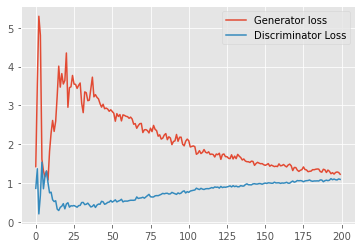

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')